The purpose of this program is to determine if common chart patterns are ideal indicators of future trends for Bitcoin.
Here are some chart patterns we will cover:
<ul>
  <li>Double Top</li>
  <li>Double Bottom</li>
  <li>Head and Shoulders</li>
  <li>Inverse Head and Shoulders</li>
  <li>Ascending Triangle</li>
  <li>Descending Triangle</li>
  <li>Bullish Pennant</li>
  <li>Bearish Pennant</li>
</ul>

The following chart patterns may or may not be covered.
<ul>
  <li>Cup and Handle</li>
  <li>Inverse Cup and Handle</li>
</ul>

The following video is used as reference when analyzing chart patterns:
[Chart Patterns](https://www.youtube.com/watch?v=sWTnFS10tdQ)

Note: For simplicity, we may not include the confirmation that traders are urged to check in the event of a false breakout.
This confirmation is used to mitigate losses if a false breakout is to occur, where the price drops back to the same level as when the breakout occurred.

[Here](https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data/code) is the link to the dataset used for this study. The dataset for this project was downloaded on 23 December 2024 and is updated daily.

In [0]:
input_file = "dbfs:/FileStore/tables/btcusd_1_min_data.csv"     # Alter file path based on your system
df_btc = spark.read.format("csv").option("header", "true").load(input_file)

In [0]:
df_btc.show(10)

+------------+----+----+----+-----+------+
|   Timestamp|Open|High| Low|Close|Volume|
+------------+----+----+----+-----+------+
|1325412060.0|4.58|4.58|4.58| 4.58|   0.0|
|1325412120.0|4.58|4.58|4.58| 4.58|   0.0|
|1325412180.0|4.58|4.58|4.58| 4.58|   0.0|
|1325412240.0|4.58|4.58|4.58| 4.58|   0.0|
|1325412300.0|4.58|4.58|4.58| 4.58|   0.0|
|1325412360.0|4.58|4.58|4.58| 4.58|   0.0|
|1325412420.0|4.58|4.58|4.58| 4.58|   0.0|
|1325412480.0|4.58|4.58|4.58| 4.58|   0.0|
|1325412540.0|4.58|4.58|4.58| 4.58|   0.0|
|1325412600.0|4.58|4.58|4.58| 4.58|   0.0|
+------------+----+----+----+-----+------+
only showing top 10 rows



In [0]:
df_btc.printSchema()

root
 |-- Timestamp: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Volume: string (nullable = true)



Need to convert to numerical data types when appropriate in order to make calculations possible.
Also, going to remove any records that contain null values.

In [0]:
from pyspark.sql.functions import col, to_timestamp, from_unixtime, dayofweek, dayofmonth, dayofyear, weekofyear, month, year

df_1min = df_btc.withColumn('Datetime', from_unixtime('Timestamp'))

df_1min = df_1min.withColumn('Datetime', to_timestamp('Datetime', 'yyyy-MM-dd HH:mm:ss'))

df_1min = df_1min.withColumn("Timestamp", col("Timestamp").cast("long"))
df_1min = df_1min.withColumn("Open", col("Open").cast("double"))
df_1min = df_1min.withColumn("High", col("High").cast("double"))
df_1min = df_1min.withColumn("Low", col("Low").cast("double"))
df_1min = df_1min.withColumn("Close", col("Close").cast("double"))
df_1min = df_1min.withColumn("Volume", col("Volume").cast("double"))

df_1min = df_1min.withColumn('Day_of_Week', dayofweek('Datetime'))
df_1min = df_1min.withColumn('Day_of_Month', dayofmonth('Datetime'))
df_1min = df_1min.withColumn('Day_of_Year', dayofyear('Datetime'))
df_1min = df_1min.withColumn('Week_of_Year', weekofyear('Datetime'))
df_1min = df_1min.withColumn('Month', month('Datetime'))
df_1min = df_1min.withColumn('Year', year('Datetime'))

df_1min = df_1min.na.drop(subset=["Timestamp", "Open", "High", "Low", "Close", "Volume", "Datetime", "Day_of_Week", "Day_of_Month", "Day_of_Year", "Week_of_Year", "Month", "Year"])

In [0]:
df_1min.show(10)

+----------+----+----+----+-----+------+-------------------+-----------+------------+-----------+------------+-----+----+
| Timestamp|Open|High| Low|Close|Volume|           Datetime|Day_of_Week|Day_of_Month|Day_of_Year|Week_of_Year|Month|Year|
+----------+----+----+----+-----+------+-------------------+-----------+------------+-----------+------------+-----+----+
|1325412060|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:01:00|          1|           1|          1|          52|    1|2012|
|1325412120|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:02:00|          1|           1|          1|          52|    1|2012|
|1325412180|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:03:00|          1|           1|          1|          52|    1|2012|
|1325412240|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:04:00|          1|           1|          1|          52|    1|2012|
|1325412300|4.58|4.58|4.58| 4.58|   0.0|2012-01-01 10:05:00|          1|           1|          1|          52|    1|2012|
|1325412360|4.58|4.58|4.

Create a dataframe of 1-day intervals to make finding trends and patterns easier.
To achieve this, get the earliest opening, the highest high, the lowest low and the latest closing price of each day.

We will use the `Day_of_year` and `Year` columns we generated earlier as our combined unique identifier for each row.

In [0]:
df_1min.createOrReplaceTempView("btc_1min")

df_1day_OHLC = sqlContext.sql("""
SELECT Day_of_Year, Year, MIN(Timestamp) AS open_time_1day, MAX(High) AS high_1day, MIN(Low) AS low_1day, MAX(Timestamp) AS close_time_1day, SUM(Volume) AS total_volume
FROM btc_1min
GROUP BY Day_of_Year, Year
ORDER BY Year, Day_of_Year""")

df_1day_OHLC.createOrReplaceTempView("btc_1day_OHLC")

df_1day_open = sqlContext.sql("""
SELECT btc_1day_OHLC.Day_of_Year AS Day_of_Year, btc_1day_OHLC.Year AS Year, Open, high_1day AS High, low_1day AS Low, total_volume AS Volume
FROM btc_1day_OHLC
INNER JOIN btc_1min
ON Timestamp = open_time_1day
ORDER BY btc_1day_OHLC.year, btc_1day_OHLC.day_of_year""")

df_1day_close = sqlContext.sql("""
SELECT btc_1day_OHLC.Day_of_Year AS Day_of_Year, btc_1day_OHLC.Year AS Year, Close
FROM btc_1day_OHLC
INNER JOIN btc_1min
ON Timestamp = close_time_1day
ORDER BY btc_1day_OHLC.year, btc_1day_OHLC.day_of_year""")

df_1day_open.createOrReplaceTempView("btc_1day_open")
df_1day_close.createOrReplaceTempView("btc_1day_close")

df_1day = sqlContext.sql("""
SELECT btc_1day_open.Day_of_Year AS Day_of_Year, btc_1day_open.Year AS Year, Open, High, Low, Close, Volume
FROM btc_1day_open
INNER JOIN btc_1day_close
ON btc_1day_open.Day_of_Year = btc_1day_close.Day_of_Year AND btc_1day_open.Year = btc_1day_close.Year
ORDER BY Year, Day_of_Year""")

from pyspark.sql.functions import round
df_1day = df_1day.withColumn('Volume', round(col('Volume'), 2))

In [0]:
# Run when needed, takes about 8 minutes
df_1day.show(10)

+-----------+----+----+----+----+-----+------+
|Day_of_Year|Year|Open|High| Low|Close|Volume|
+-----------+----+----+----+----+-----+------+
|          1|2012|4.58|4.84|4.58| 4.84|  10.0|
|          2|2012|4.84| 5.0|4.84|  5.0|  10.1|
|          3|2012| 5.0|5.32| 5.0| 5.29|107.09|
|          4|2012|5.29|5.57|4.93| 5.57|107.23|
|          5|2012|5.57|6.46|5.57| 6.42| 70.33|
|          6|2012|6.42| 6.9| 6.4|  6.4| 55.86|
|          7|2012| 6.4| 6.8| 6.0|  6.8|   2.8|
|          8|2012| 6.8| 6.9| 6.8|  6.9|   4.0|
|          9|2012| 6.9| 7.0|6.36| 6.48| 64.87|
|         10|2012|6.48| 7.1|6.23|  7.1| 60.69|
+-----------+----+----+----+----+-----+------+
only showing top 10 rows



In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import avg

window20 = Window.orderBy(['Year', 'Day_of_Year']).rowsBetween(-20, 0)
df_1day = df_1day.withColumn('20MA', round(avg('Open').over(window20), 2))

window50 = Window.orderBy(['Year', 'Day_of_Year']).rowsBetween(-50, 0)
df_1day = df_1day.withColumn('50MA', round(avg('Open').over(window50), 2))

window100 = Window.orderBy(['Year', 'Day_of_Year']).rowsBetween(-100, 0)
df_1day = df_1day.withColumn('100MA', round(avg('Open').over(window100), 2))

In [0]:
# Run when needed, takes about 8 minutes
df_1day.show(10)

+-----------+----+----+----+----+-----+------+----+----+-----+
|Day_of_Year|Year|Open|High| Low|Close|Volume|20MA|50MA|100MA|
+-----------+----+----+----+----+-----+------+----+----+-----+
|          1|2012|4.58|4.84|4.58| 4.84|  10.0|4.58|4.58| 4.58|
|          2|2012|4.84| 5.0|4.84|  5.0|  10.1|4.71|4.71| 4.71|
|          3|2012| 5.0|5.32| 5.0| 5.29|107.09|4.81|4.81| 4.81|
|          4|2012|5.29|5.57|4.93| 5.57|107.23|4.93|4.93| 4.93|
|          5|2012|5.57|6.46|5.57| 6.42| 70.33|5.06|5.06| 5.06|
|          6|2012|6.42| 6.9| 6.4|  6.4| 55.86|5.28|5.28| 5.28|
|          7|2012| 6.4| 6.8| 6.0|  6.8|   2.8|5.44|5.44| 5.44|
|          8|2012| 6.8| 6.9| 6.8|  6.9|   4.0|5.61|5.61| 5.61|
|          9|2012| 6.9| 7.0|6.36| 6.48| 64.87|5.76|5.76| 5.76|
|         10|2012|6.48| 7.1|6.23|  7.1| 60.69|5.83|5.83| 5.83|
+-----------+----+----+----+----+-----+------+----+----+-----+
only showing top 10 rows



We can display the moving averages using a line graph. 20, 50 and 100 moving average are yellow, orange and red, respectively. We will also display the opening prices in blue.

In [0]:
import matplotlib.pyplot as plt
import numpy as np

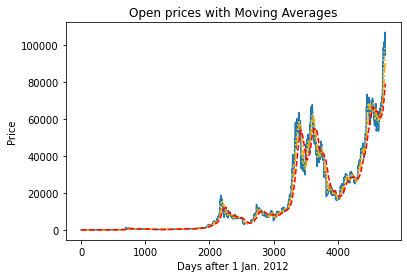

In [0]:
x = np.array(list(range(df_1day.count())))

y = np.array(list(df_1day.select('Open').toPandas()['Open']))
plt.plot(x, y)

y20 =  np.array(list(df_1day.select('20MA').toPandas()['20MA']))
y50 =  np.array(list(df_1day.select('50MA').toPandas()['50MA']))
y100 = np.array(list(df_1day.select('100MA').toPandas()['100MA']))
plt.plot(x, y20, ':', color='gold')
plt.plot(x, y50, '-.', color='orange')
plt.plot(x, y100, '--', color='red')

plt.xlabel("Days after 1 Jan. 2012")
plt.ylabel("Price")
plt.title('Open prices with Moving Averages')
plt.show()

It may be difficult to see the differences between the moving averages and the BTC prices, so we will also include the chart for only each year seperately.

In [0]:
# Note: Program may time-out before displaying the results because the Spark cluster in DataBricks terminates after 60 minutes. It takes about 30-35 minutes to display each chart, so the program does not finish computing the next cell.

In [0]:
curr_year = 2012
df_1day.createOrReplaceTempView("btc_1day")

df_year = sqlContext.sql("SELECT * FROM btc_1day WHERE Year = "
                            + str(curr_year)
                            + " ORDER BY Year, Day_of_Year")

x = np.array(list(range(df_year.count())))

y = np.array(list(df_year.select('Open').toPandas()['Open']))
plt.plot(x, y)

y20 =  np.array(list(df_year.select('20MA').toPandas()['20MA']))
y50 =  np.array(list(df_year.select('50MA').toPandas()['50MA']))
y100 = np.array(list(df_year.select('100MA').toPandas()['100MA']))
plt.plot(x, y20, ':', color='gold')
plt.plot(x, y50, '-.', color='orange')
plt.plot(x, y100, '--', color='red')

plt.xlabel(("Days of " + str(curr_year)))
plt.ylabel("Price")
plt.title(("Open prices in " + str(curr_year) + " with Moving Averages"))
plt.show()

In [0]:
curr_year = 2013
df_1day.createOrReplaceTempView("btc_1day")

df_year = sqlContext.sql("SELECT * FROM btc_1day WHERE Year = "
                            + str(curr_year)
                            + " ORDER BY Year, Day_of_Year")

x = np.array(list(range(df_year.count())))

y = np.array(list(df_year.select('Open').toPandas()['Open']))
plt.plot(x, y)

y20 =  np.array(list(df_year.select('20MA').toPandas()['20MA']))
y50 =  np.array(list(df_year.select('50MA').toPandas()['50MA']))
y100 = np.array(list(df_year.select('100MA').toPandas()['100MA']))
plt.plot(x, y20, ':', color='gold')
plt.plot(x, y50, '-.', color='orange')
plt.plot(x, y100, '--', color='red')

plt.xlabel(("Days of " + str(curr_year)))
plt.ylabel("Price")
plt.title(("Open prices in " + str(curr_year) + " with Moving Averages"))
plt.show()

In [0]:
curr_year = 2014
df_1day.createOrReplaceTempView("btc_1day")

df_year = sqlContext.sql("SELECT * FROM btc_1day WHERE Year = "
                            + str(curr_year)
                            + " ORDER BY Year, Day_of_Year")

x = np.array(list(range(df_year.count())))

y = np.array(list(df_year.select('Open').toPandas()['Open']))
plt.plot(x, y)

y20 =  np.array(list(df_year.select('20MA').toPandas()['20MA']))
y50 =  np.array(list(df_year.select('50MA').toPandas()['50MA']))
y100 = np.array(list(df_year.select('100MA').toPandas()['100MA']))
plt.plot(x, y20, ':', color='gold')
plt.plot(x, y50, '-.', color='orange')
plt.plot(x, y100, '--', color='red')

plt.xlabel(("Days of " + str(curr_year)))
plt.ylabel("Price")
plt.title(("Open prices in " + str(curr_year) + " with Moving Averages"))
plt.show()

In [0]:
curr_year = 2015
df_1day.createOrReplaceTempView("btc_1day")

df_year = sqlContext.sql("SELECT * FROM btc_1day WHERE Year = "
                            + str(curr_year)
                            + " ORDER BY Year, Day_of_Year")

x = np.array(list(range(df_year.count())))

y = np.array(list(df_year.select('Open').toPandas()['Open']))
plt.plot(x, y)

y20 =  np.array(list(df_year.select('20MA').toPandas()['20MA']))
y50 =  np.array(list(df_year.select('50MA').toPandas()['50MA']))
y100 = np.array(list(df_year.select('100MA').toPandas()['100MA']))
plt.plot(x, y20, ':', color='gold')
plt.plot(x, y50, '-.', color='orange')
plt.plot(x, y100, '--', color='red')

plt.xlabel(("Days of " + str(curr_year)))
plt.ylabel("Price")
plt.title(("Open prices in " + str(curr_year) + " with Moving Averages"))
plt.show()

In [0]:
curr_year = 2016
df_1day.createOrReplaceTempView("btc_1day")

df_year = sqlContext.sql("SELECT * FROM btc_1day WHERE Year = "
                            + str(curr_year)
                            + " ORDER BY Year, Day_of_Year")

x = np.array(list(range(df_year.count())))

y = np.array(list(df_year.select('Open').toPandas()['Open']))
plt.plot(x, y)

y20 =  np.array(list(df_year.select('20MA').toPandas()['20MA']))
y50 =  np.array(list(df_year.select('50MA').toPandas()['50MA']))
y100 = np.array(list(df_year.select('100MA').toPandas()['100MA']))
plt.plot(x, y20, ':', color='gold')
plt.plot(x, y50, '-.', color='orange')
plt.plot(x, y100, '--', color='red')

plt.xlabel(("Days of " + str(curr_year)))
plt.ylabel("Price")
plt.title(("Open prices in " + str(curr_year) + " with Moving Averages"))
plt.show()

In [0]:
curr_year = 2017
df_1day.createOrReplaceTempView("btc_1day")

df_year = sqlContext.sql("SELECT * FROM btc_1day WHERE Year = "
                            + str(curr_year)
                            + " ORDER BY Year, Day_of_Year")

x = np.array(list(range(df_year.count())))

y = np.array(list(df_year.select('Open').toPandas()['Open']))
plt.plot(x, y)

y20 =  np.array(list(df_year.select('20MA').toPandas()['20MA']))
y50 =  np.array(list(df_year.select('50MA').toPandas()['50MA']))
y100 = np.array(list(df_year.select('100MA').toPandas()['100MA']))
plt.plot(x, y20, ':', color='gold')
plt.plot(x, y50, '-.', color='orange')
plt.plot(x, y100, '--', color='red')

plt.xlabel(("Days of " + str(curr_year)))
plt.ylabel("Price")
plt.title(("Open prices in " + str(curr_year) + " with Moving Averages"))
plt.show()

In [0]:
curr_year = 2018
df_1day.createOrReplaceTempView("btc_1day")

df_year = sqlContext.sql("SELECT * FROM btc_1day WHERE Year = "
                            + str(curr_year)
                            + " ORDER BY Year, Day_of_Year")

x = np.array(list(range(df_year.count())))

y = np.array(list(df_year.select('Open').toPandas()['Open']))
plt.plot(x, y)

y20 =  np.array(list(df_year.select('20MA').toPandas()['20MA']))
y50 =  np.array(list(df_year.select('50MA').toPandas()['50MA']))
y100 = np.array(list(df_year.select('100MA').toPandas()['100MA']))
plt.plot(x, y20, ':', color='gold')
plt.plot(x, y50, '-.', color='orange')
plt.plot(x, y100, '--', color='red')

plt.xlabel(("Days of " + str(curr_year)))
plt.ylabel("Price")
plt.title(("Open prices in " + str(curr_year) + " with Moving Averages"))
plt.show()

In [0]:
curr_year = 2019
df_1day.createOrReplaceTempView("btc_1day")

df_year = sqlContext.sql("SELECT * FROM btc_1day WHERE Year = "
                            + str(curr_year)
                            + " ORDER BY Year, Day_of_Year")

x = np.array(list(range(df_year.count())))

y = np.array(list(df_year.select('Open').toPandas()['Open']))
plt.plot(x, y)

y20 =  np.array(list(df_year.select('20MA').toPandas()['20MA']))
y50 =  np.array(list(df_year.select('50MA').toPandas()['50MA']))
y100 = np.array(list(df_year.select('100MA').toPandas()['100MA']))
plt.plot(x, y20, ':', color='gold')
plt.plot(x, y50, '-.', color='orange')
plt.plot(x, y100, '--', color='red')

plt.xlabel(("Days of " + str(curr_year)))
plt.ylabel("Price")
plt.title(("Open prices in " + str(curr_year) + " with Moving Averages"))
plt.show()

In [0]:
curr_year = 2020
df_1day.createOrReplaceTempView("btc_1day")

df_year = sqlContext.sql("SELECT * FROM btc_1day WHERE Year = "
                            + str(curr_year)
                            + " ORDER BY Year, Day_of_Year")

x = np.array(list(range(df_year.count())))

y = np.array(list(df_year.select('Open').toPandas()['Open']))
plt.plot(x, y)

y20 =  np.array(list(df_year.select('20MA').toPandas()['20MA']))
y50 =  np.array(list(df_year.select('50MA').toPandas()['50MA']))
y100 = np.array(list(df_year.select('100MA').toPandas()['100MA']))
plt.plot(x, y20, ':', color='gold')
plt.plot(x, y50, '-.', color='orange')
plt.plot(x, y100, '--', color='red')

plt.xlabel(("Days of " + str(curr_year)))
plt.ylabel("Price")
plt.title(("Open prices in " + str(curr_year) + " with Moving Averages"))
plt.show()

In [0]:
curr_year = 2021
df_1day.createOrReplaceTempView("btc_1day")

df_year = sqlContext.sql("SELECT * FROM btc_1day WHERE Year = "
                            + str(curr_year)
                            + " ORDER BY Year, Day_of_Year")

x = np.array(list(range(df_year.count())))

y = np.array(list(df_year.select('Open').toPandas()['Open']))
plt.plot(x, y)

y20 =  np.array(list(df_year.select('20MA').toPandas()['20MA']))
y50 =  np.array(list(df_year.select('50MA').toPandas()['50MA']))
y100 = np.array(list(df_year.select('100MA').toPandas()['100MA']))
plt.plot(x, y20, ':', color='gold')
plt.plot(x, y50, '-.', color='orange')
plt.plot(x, y100, '--', color='red')

plt.xlabel(("Days of " + str(curr_year)))
plt.ylabel("Price")
plt.title(("Open prices in " + str(curr_year) + " with Moving Averages"))
plt.show()

In [0]:
curr_year = 2022
df_1day.createOrReplaceTempView("btc_1day")

df_year = sqlContext.sql("SELECT * FROM btc_1day WHERE Year = "
                            + str(curr_year)
                            + " ORDER BY Year, Day_of_Year")

x = np.array(list(range(df_year.count())))

y = np.array(list(df_year.select('Open').toPandas()['Open']))
plt.plot(x, y)

y20 =  np.array(list(df_year.select('20MA').toPandas()['20MA']))
y50 =  np.array(list(df_year.select('50MA').toPandas()['50MA']))
y100 = np.array(list(df_year.select('100MA').toPandas()['100MA']))
plt.plot(x, y20, ':', color='gold')
plt.plot(x, y50, '-.', color='orange')
plt.plot(x, y100, '--', color='red')

plt.xlabel(("Days of " + str(curr_year)))
plt.ylabel("Price")
plt.title(("Open prices in " + str(curr_year) + " with Moving Averages"))
plt.show()

In [0]:
curr_year = 2023
df_1day.createOrReplaceTempView("btc_1day")

df_year = sqlContext.sql("SELECT * FROM btc_1day WHERE Year = "
                            + str(curr_year)
                            + " ORDER BY Year, Day_of_Year")

x = np.array(list(range(df_year.count())))

y = np.array(list(df_year.select('Open').toPandas()['Open']))
plt.plot(x, y)

y20 =  np.array(list(df_year.select('20MA').toPandas()['20MA']))
y50 =  np.array(list(df_year.select('50MA').toPandas()['50MA']))
y100 = np.array(list(df_year.select('100MA').toPandas()['100MA']))
plt.plot(x, y20, ':', color='gold')
plt.plot(x, y50, '-.', color='orange')
plt.plot(x, y100, '--', color='red')

plt.xlabel(("Days of " + str(curr_year)))
plt.ylabel("Price")
plt.title(("Open prices in " + str(curr_year) + " with Moving Averages"))
plt.show()

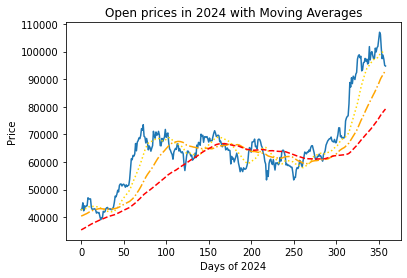

In [0]:
curr_year = 2024
df_1day.createOrReplaceTempView("btc_1day")

df_year = sqlContext.sql("SELECT * FROM btc_1day WHERE Year = "
                            + str(curr_year)
                            + " ORDER BY Year, Day_of_Year")

x = np.array(list(range(df_year.count())))

y = np.array(list(df_year.select('Open').toPandas()['Open']))
plt.plot(x, y)

y20 =  np.array(list(df_year.select('20MA').toPandas()['20MA']))
y50 =  np.array(list(df_year.select('50MA').toPandas()['50MA']))
y100 = np.array(list(df_year.select('100MA').toPandas()['100MA']))
plt.plot(x, y20, ':', color='gold')
plt.plot(x, y50, '-.', color='orange')
plt.plot(x, y100, '--', color='red')

plt.xlabel(("Days of " + str(curr_year)))
plt.ylabel("Price")
plt.title(("Open prices in " + str(curr_year) + " with Moving Averages"))
plt.show()